<a href="https://colab.research.google.com/github/SYKIM5396/TIL/blob/main/ROC_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/cardio/cardio_train.csv', sep=';')

In [4]:
df.drop("id",axis=1, inplace=True)

In [5]:
# 훈련셋 테스트셋 나누기
X = df.drop('cardio', axis=1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

numeric_feats = ['age','height','weight','ap_hi','ap_lo']

scaler = StandardScaler()
X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_val[numeric_feats] = scaler.transform(X_val[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])

#원핫인코딩
ohe = OneHotEncoder(use_cat_names=True, cols = ['gender'])

X_train_ohe = ohe.fit_transform(X_train)
X_val_ohe = ohe.transform(X_val)
X_test_ohe = ohe.transform(X_test)

In [6]:
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train_ohe, y_train)

LogisticRegression(max_iter=1000)

In [7]:
# 사이킷런 라이브러리 없이 TPR, FPR 구하는 함수
def calculate_prs(y_pred_proba, y_real, threshold):
    TPR = 0.0
    FPR = 0.0

    # YOUR CODE HERE
    y_pred = y_pred_proba > threshold
    
    tp = sum((y_pred == 1) & (y_real == 1))
    tn = sum((y_pred != 1) & (y_real != 1))
    fp = sum((y_pred == 1) & (y_real != 1))
    fn = sum((y_pred != 1) & (y_real == 1))
    
    TPR = tp / (tp + fn)
    FPR = fp / (fp + tn)
    # YOUR CODE ENDS HERE

    return TPR, FPR

optimal_threshold=0.48, optimal_tpr=0.71, optimal_fpr=0.26


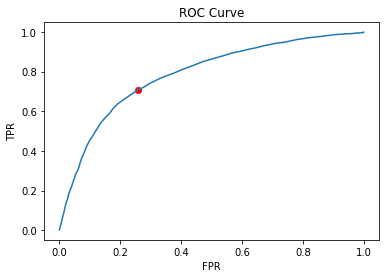

In [8]:
import matplotlib.pyplot as plt

y_pred_proba = logistic.predict_proba(X_test_ohe)[:,1]
y_real = y_test
thresholds = np.arange(0.01,1,0.01)
tprs, fprs = [], []

for th in thresholds:
    tprs.append(calculate_prs(y_pred_proba, y_real, th)[0])
    fprs.append(calculate_prs(y_pred_proba, y_real, th)[1])

#TPR이 최대가 되고 FPR이 최소가 되는 지점 : 최적의 임계값
optimal_idx = np.argmax(np.array(tprs) - np.array(fprs))
optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tprs[optimal_idx]
optimal_fpr = fprs[optimal_idx]

print("optimal_threshold={}, optimal_tpr={}, optimal_fpr={}".format(round(optimal_threshold,2),round(optimal_tpr,2),round(optimal_fpr,2)))

plt.scatter(optimal_fpr, optimal_tpr, color = 'red', alpha=1, label='Optimal Threshold')
plt.plot(fprs, tprs)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred_proba)
print(f"auc score : {auc.round(3)}")

auc score : 0.785
